In [18]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py
import time
from scipy.spatial import cKDTree
#from scipy.spatial import distance
from tqdm import tqdm

In [6]:
pop_file_loc = "/home/pranavsatheesh/host_galaxies/data/population_files/"
pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut.hdf5"

In [7]:
pop = h5py.File(pop_file, 'r')
# Mstar_merging = pop['merging_population']['Mstar'][:]
# Mstar_non_merging = pop['non_merging_population']['Mstar'][:]

In [10]:
pop['merging_population'].keys()

<KeysViewHDF5 ['MBH', 'MBH_1', 'MBH_2', 'Mdot', 'Mgas', 'Mstar', 'SFR', 'q_merger', 'snap', 'subhalo_ids', 'z']>

### Algorithm 1: Assigning a weight to each galaxies 

In [5]:
def generate_control_sample_restrictive(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10 and Mstar_dex_tol < 0.3):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"].append(z_tol)
        control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [10]:
def generate_control_sample(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"]=np.append(control_sample["z_tol"],z_tol)
        control_sample["Mstar_dex_tol"]=np.append(control_sample["Mstar_dex_tol"],Mstar_dex_tol)
       #control_sample["z_tol"].append(z_tol)
        #control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [11]:
control_def = generate_control_sample(pop)
control_restrictive = generate_control_sample_restrictive(pop)

Elapsed time: 28.67768144607544 seconds
Elapsed time: 28.13616156578064 seconds


## Algorithm 2: Using KS matching and KDTrees

In [67]:
pop['merging_population'].keys()
print(np.min(pop['merging_population']['q_merger']))
print(np.min(np.log10(pop['merging_population']['Mstar'])))

0.10072685274193992
7.152853985801412


In [16]:
N_mergers = len(pop['merging_population']['MBH'])
print(N_mergers)
N_non_mergers = len(pop['non_merging_population']['MBH'])
print(N_non_mergers)

444
1524708


In [19]:
control_indices = np.arange(0,N_non_mergers)
control_mask = np.ones(N_non_mergers, dtype=bool)
print(control_mask)

[ True  True  True ...  True  True  True]


In [20]:
merging_points = np.column_stack((pop['merging_population']['z'], np.log10(pop['merging_population']['Mstar'])))
non_merging_points = np.column_stack((pop['non_merging_population']['z'], np.log10(pop['non_merging_population']['Mstar'])))

# Build a KDTree for fast nearest neighbor search
tree = cKDTree(non_merging_points)

# Track used indices
used = np.zeros(len(non_merging_points), dtype=bool)  # False means available
#closest_indices = np.full(len(merging_points), -1)  # Store assigned indices

control_indices = []

p_z = 1.0  # or set an initial value
p_Mstar = 1.0  # or set an initial value

# Perform the loop with initial values
while True:
    closest_indices = np.full(len(merging_points), -1)  # Store assigned indices

    for i in tqdm(range(len(merging_points)), desc="Processing merging points", ncols=100):
    #for i in range(len(merging_points)):
    # Find the closest available neighbor
        d, min_index = tree.query(merging_points[i])

        if (used[min_index]): # If already taken, find the next closest manually
            dists, idxs = tree.query(merging_points[i], k=len(non_merging_points))  # Get sorted neighbor
            min_index = idxs[np.where(~used[idxs])[0][0]]  # Find first unused index


        # Ensure we select an unused index
        #while used[min_index]:  # If already taken, find the next closest manually
            #dists, idxs = tree.query(merging_points[i], k=len(non_merging_points))  # Get sorted neighbors
            #min_index = idxs[np.where(~used[idxs])[0][0]]  # Find first unused index
        
        # Store the match and mark as used
        closest_indices[i] = min_index
        used[min_index] = True  # Mark as used

    control_indices.append(closest_indices)
    print(len(pop['non_merging_population']['Mstar'][np.sort(closest_indices)]),len(pop['non_merging_population']['z'][np.sort(closest_indices)]))

    D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][np.sort(closest_indices)],pop['merging_population']['Mstar'])
    D_z, p_z = ks_2samp(pop['non_merging_population']['z'][np.sort(closest_indices)],pop['merging_population']['z'])
    print(p_z,p_Mstar,np.shape(control_indices)[0])
    
    if p_z < 0.99 or p_Mstar < 0.99 or np.shape(control_indices)[0]>=10:
        
        break  # Exit the loop if both conditions are no longer true

# `closest_indices` now contains the nearest non-merging index for each merging point without replacement.

Processing merging points: 100%|█████████████████████████████████| 444/444 [00:03<00:00, 114.88it/s]


444 444
1.0 0.9999999999999998 1


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:06<00:00,  3.50it/s]


444 444
1.0 0.9999999999999998 2


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.49it/s]


444 444
0.9999999999999999 0.9999999999999998 3


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.49it/s]


444 444
0.9999999999999999 0.999999999999469 4


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.47it/s]


444 444
0.9999999999999999 0.9999999982785098 5


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.47it/s]


444 444
0.9999896420993635 0.999999999999469 6


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.48it/s]


444 444
0.9999896420993635 0.9999999982785098 7


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.48it/s]


444 444
0.999875286370536 0.9999996923996428 8


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:07<00:00,  3.48it/s]


444 444
0.999875286370536 0.9999896420993635 9


Processing merging points: 100%|██████████████████████████████████| 444/444 [02:19<00:00,  3.19it/s]


444 444
0.999999999999469 0.999875286370536 10


In [24]:
sorted_indices = np.sort(closest_indices)
D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][sorted_indices],pop['merging_population']['Mstar'])

In [34]:
Mstar_binsize = 0.5  # specify the binsize
Mstar_min = 7
Mstar_max = 12
Nbins_Ms = int((Mstar_max-Mstar_min)/Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min,Mstar_max,Nbins_Ms)

z_binsize = 0.6
z_min = 0
z_max = 5
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

Text(0.5, 0, '$\\log(M_{\\star}/M_{\\odot})$')

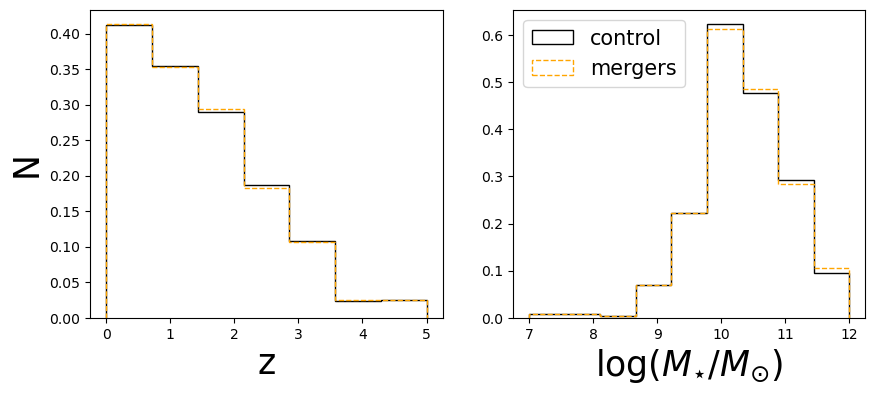

In [68]:
control_sample_ids = np.array(control_indices).flatten()

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(pop['non_merging_population']['z'][np.sort(control_sample_ids)], bins=z_bins, color="black", histtype="step",density=True)
ax[0].hist(pop['merging_population']['z'], bins=z_bins, histtype="step",color="orange",linestyle="--",density=True)
ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("N",fontsize=25)


ax[1].hist(np.log10(pop['non_merging_population']['Mstar'][np.sort(control_sample_ids)]), bins=Mstar_bins,histtype="step",color="black",label="control",density=True)
ax[1].hist(np.log10(pop['merging_population']['Mstar']),bins=Mstar_bins,histtype="step",label="mergers",color="orange",linestyle="--",density=True)

ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)


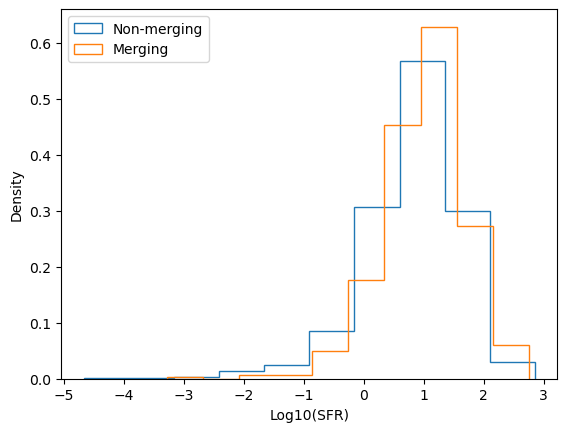

In [49]:
# Filter out non-positive SFR values
sfr_non_merging = pop['non_merging_population']['SFR'][np.sort(control_z)][:]
sfr_merging = pop['merging_population']['SFR'][:]

# Remove any non-positive values (SFR <= 0)
log_sfr_non_merging = np.log10(sfr_non_merging[sfr_non_merging > 0])
log_sfr_merging = np.log10(sfr_merging[sfr_merging > 0])

# Create the histograms for both distributions, normalized to the same area (density=True)
plt.hist(log_sfr_non_merging, histtype="step", density=True, bins=10, label="Non-merging")
plt.hist(log_sfr_merging, histtype="step", density=True, bins=10, label="Merging")

# Add a legend and axis labels
plt.legend()
plt.xlabel("Log10(SFR)")
plt.ylabel("Density")
plt.show()

In [60]:
np.median(10**log_sfr_merging)/np.median(10**log_sfr_non_merging)

1.3755364977734479

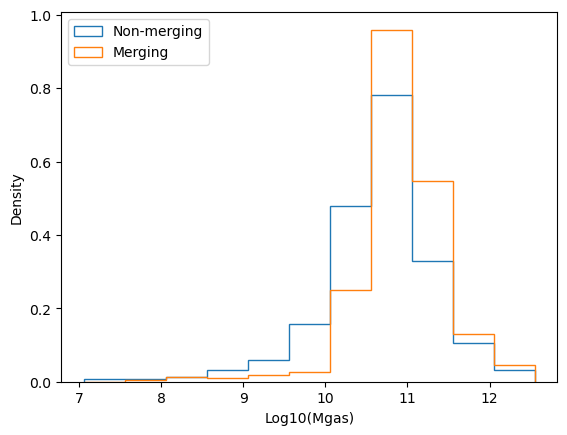

In [54]:
# Filter out non-positive Mgas values
log_mgas_non_merging = np.log10(pop['non_merging_population']['Mgas'][np.sort(control_z)])
log_mgas_merging = np.log10(pop['merging_population']['Mgas'])

# Remove any non-positive values (Mgas <= 0)
log_mgas_non_merging = log_mgas_non_merging[log_mgas_non_merging > 0]
log_mgas_merging = log_mgas_merging[log_mgas_merging > 0]

# Define the bins for Mgas (logarithmic bins or linear bins depending on your needs)
bins = np.linspace(np.min(log_mgas_non_merging),np.max(log_mgas_non_merging), 12)

# Create the histograms for both distributions, normalized to the same area (density=True)
plt.hist(log_mgas_non_merging, histtype="step", density=True, bins=bins, label="Non-merging")
plt.hist(log_mgas_merging, histtype="step", density=True, bins=bins, label="Merging")


# Add a legend and axis labels
plt.legend()
#plt.xscale('log')  # Use logarithmic x-axis for better visibility
plt.xlabel("Log10(Mgas)")
plt.ylabel("Density")
plt.show()
